In [1]:
import numpy as np
import pandas as pd 
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, randint

from numpy import mean, std, dstack

from pandas import read_csv

from keras import backend as K
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Flatten, Dropout, Conv1D, LSTM, GRU,
                          TimeDistributed, GlobalAveragePooling1D, MaxPooling1D)
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam, RMSprop,SGD
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from scipy import signal

%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))
    
# Check GPU support 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python

10
20
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9154822565512771164
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16928312671725740179
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9212819769946541890
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3402498048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7402675909914097878
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


change current directory for access to dataset and signal analysis core

In [2]:
from os import chdir as cd
cd('..')

### Import display graphics functions

In [3]:
from core.display_functions import display_block_of_values

# 1 Upload and preproccesing production dataset with synthetic anomalies

### 1.1 Read dataset

In [4]:
from core.controller import SignalController
signals = SignalController(filepath="datasets/L1_10-12.18.csv", 
                           rolling_window_size=500, 
                           minimal_anomaly_length=50, 
                           sample_rate=40, 
                           encoding="cp1251", delimiter=",", 
                           corr_threshold=0.9, 
                           smooth_method='savgol', 
                           target_variable=None)

Number of columns: 96
Number of columns after corr analysis: 52
Number of columns after clean: 41
NaN Values: False
Successfully scaled control_results
savgol filter smoothing successful


### display non smooth dataset 

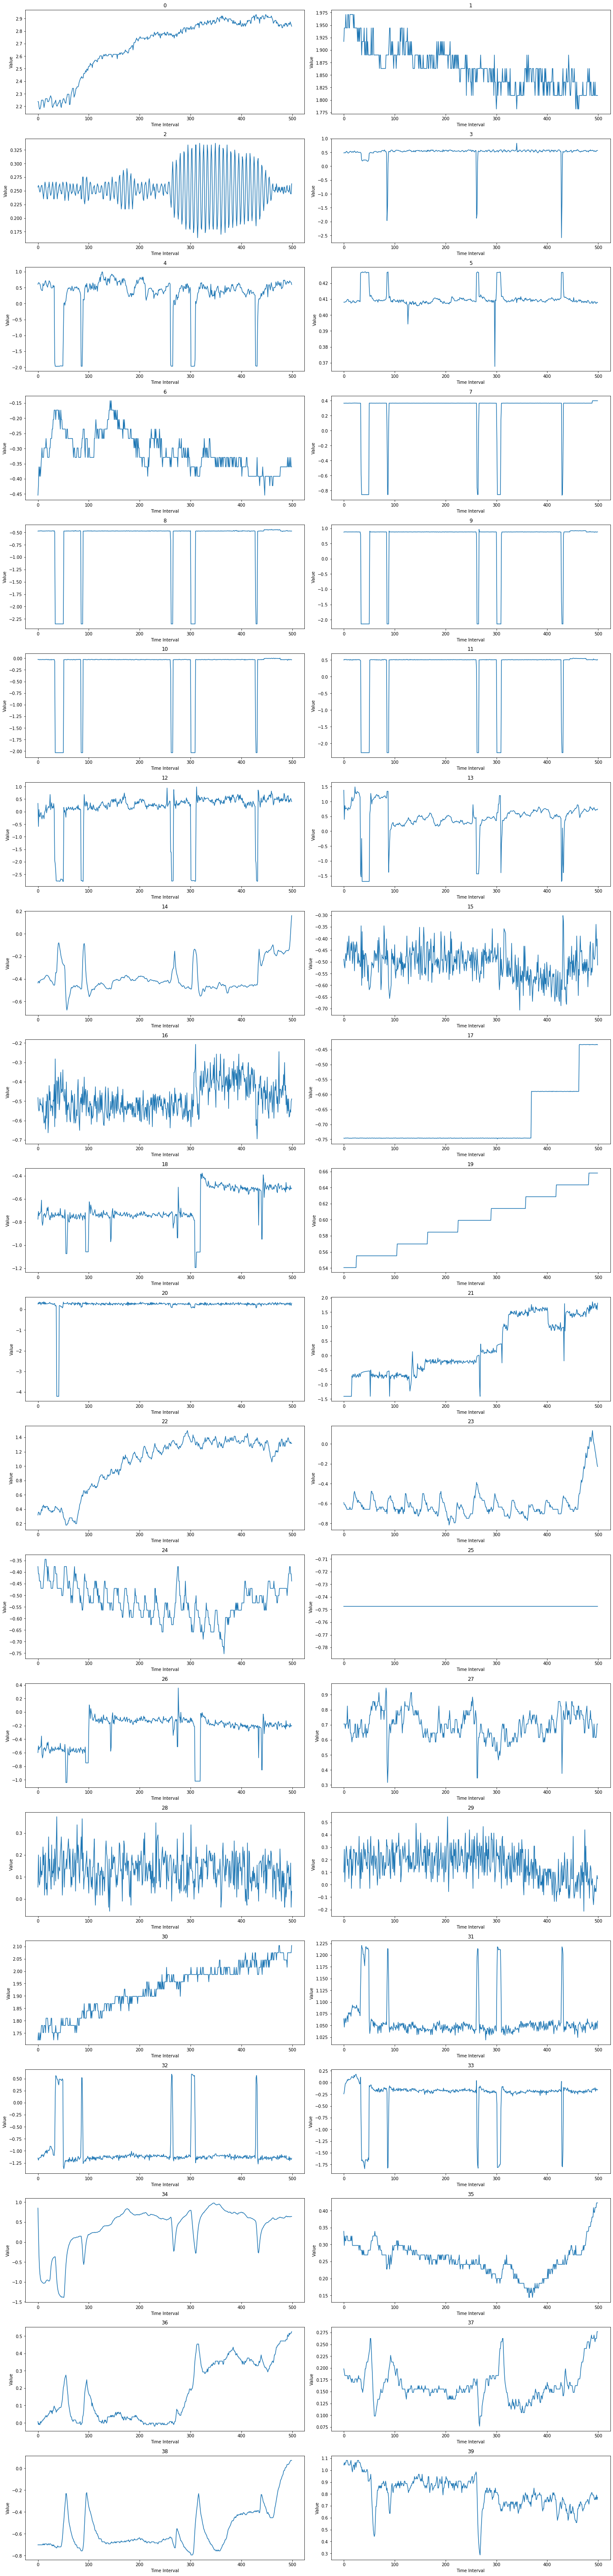

In [6]:
display_block_of_values(signals.scaled_control_results.iloc[:500],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

### display savgol filter dataset 

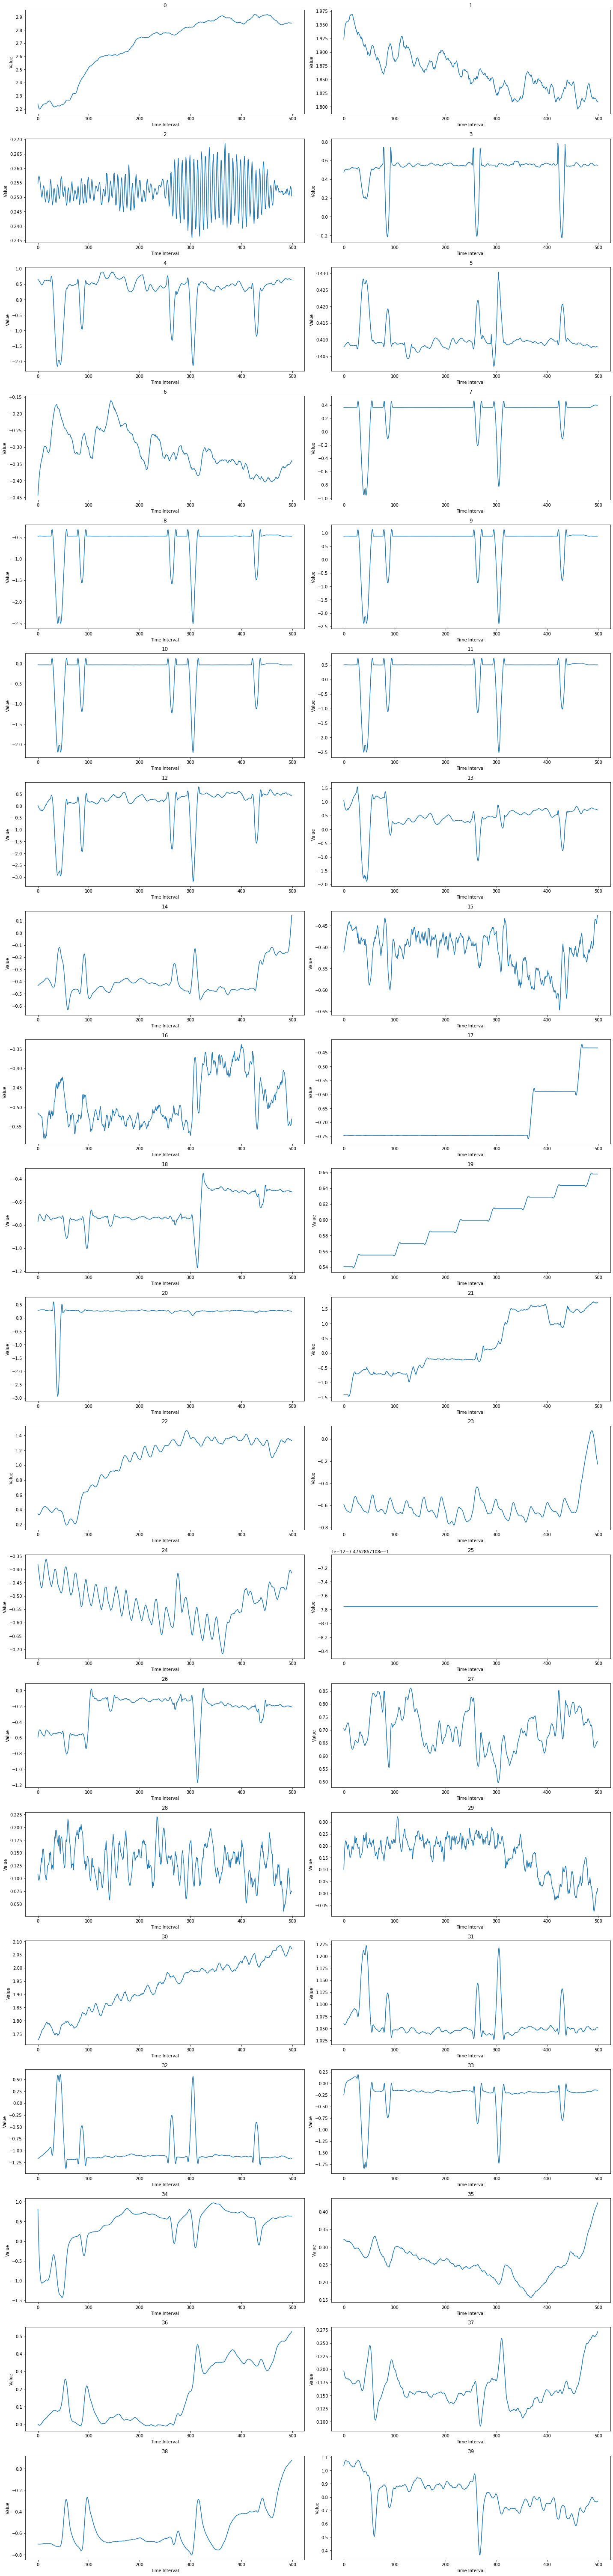

In [7]:
display_block_of_values(signals.smoothed_control_results.iloc[:500],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

# Principal component analysis 2d and 3d

Объясненная вариация по основному компоненту: [9.96203154e-01 2.62617028e-03 7.39510135e-04]


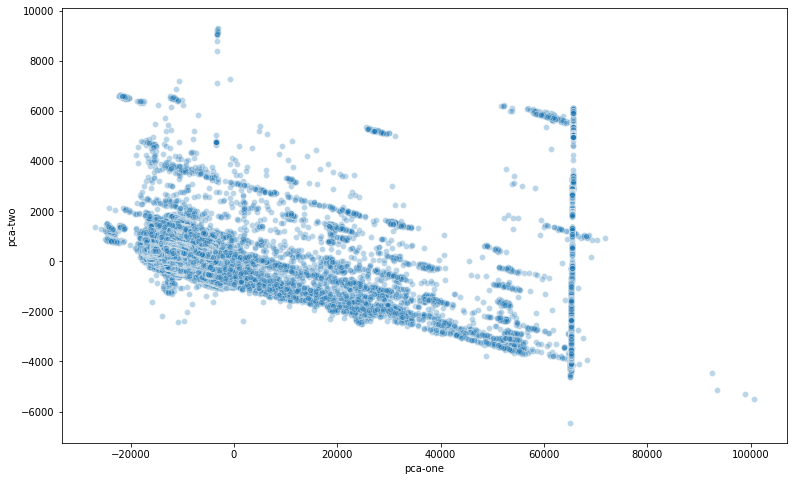

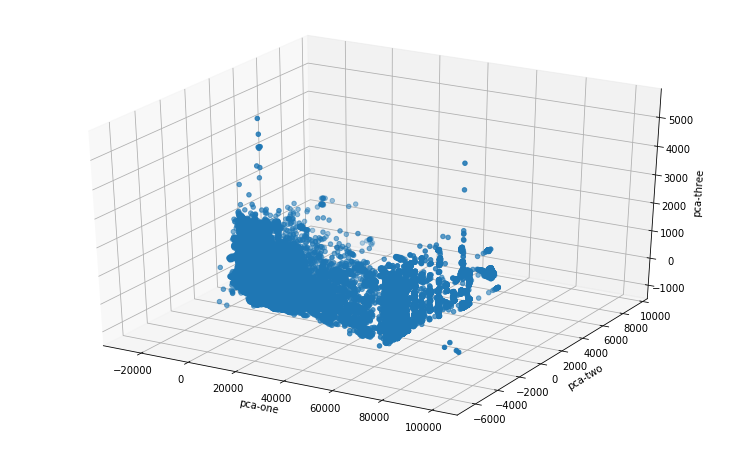

In [28]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(signals.control_results.values)

signals.control_results['pca-one'] = pca_result[:,0]
signals.control_results['pca-two'] = pca_result[:,1] 
signals.control_results['pca-three'] = pca_result[:,2]

print('Объясненная вариация по основному компоненту: {}'.format(pca.explained_variance_ratio_))


plt.figure(figsize=(13,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=signals.control_results,
    legend="full",
    alpha=0.3
)

ax = plt.figure(figsize=(13,8)).gca(projection='3d')
ax.scatter(
    xs=signals.control_results["pca-one"], 
    ys=signals.control_results["pca-two"], 
    zs=signals.control_results["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Anomaly generation 

In [5]:
signals.smoothed_control_results.head()

0         1         2         3         4         5         6   \
0  2.237506  1.923655  0.254768  0.474581  0.652568  0.407851 -0.443597   
1  2.216951  1.935319  0.256701  0.489323  0.638199  0.407992 -0.419420   
2  2.204628  1.943786  0.257326  0.498924  0.616719  0.408178 -0.399012   
3  2.199181  1.949549  0.256915  0.504292  0.590622  0.408393 -0.381951   
4  2.199257  1.953100  0.255741  0.506341  0.562402  0.408617 -0.367814   

         7         8         9   ...        30        31        32        33  \
0  0.365078 -0.472837  0.877262  ...  1.726944  1.059932 -1.172624 -0.248912   
1  0.365014 -0.470468  0.879852  ...  1.729208  1.058076 -1.163343 -0.166393   
2  0.365001 -0.468877  0.881551  ...  1.732524  1.057584 -1.154580 -0.100356   
3  0.365028 -0.467954  0.882498  ...  1.736679  1.058218 -1.146242 -0.048925   
4  0.365086 -0.467590  0.882832  ...  1.741458  1.059741 -1.138234 -0.010221   

         34        35        36        37        38        39  
0  0.807711  0.321803  0.001642  0.196857 -0.701018  1.035483  
1  0.233061  0.320983 -0.002576  0.191402 -0.701399  1.054074  
2 -0.213775  0.320011 -0.004874  0.187366 -0.701624  1.066086  
3 -0.547880  0.318946 -0.005489  0.184548 -0.701700  1.072556  
4 -0.784334  0.317846 -0.004661  0.182750 -0.701632  1.074526  

[5 rows x 40 columns]

In [6]:
signal_samples = signals.get_sliced_signal
anomaly_signal_samples = signals.generate_anomalies(signal_samples)

In [ ]:
def display_signal_with_anomalies(samples , x_label='x_label', y_label='y_label',figsize=(15,30), plot_size=(15,3)):
    plt.figure(figsize=figsize)
    sample_number = 0
    print(samples.values.shape)
    for plot in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0],plot_size[1], plot+1)
        plt.plot(signal_samples[1].values[:,plot])
        plt.plot(anomaly_signal_samples[1].values[: , plot])
        plt.title(plot)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()
        sample_number += 1

display_signal_with_anomalies(samples=anomaly_signal_samples[1],
                              x_label='timeline', 
                              y_label='y_label',
                              figsize=(20,100), 
                              plot_size=(24,2))

# Convolutional Neural Network with flatten exit 

Concate anomaly signals and normal signals, and shufffle them for normal distribution

In [62]:
X_data = anomaly_signal_samples + signal_samples
shuffle(X_data)

Get train and test data sets in list of Signal classes format 

In [63]:
train_list, test_list = train_test_split(X_data, test_size=0.33, random_state=42)
print(len(train_list))
print(len(test_list))
print(train_list[2500].abnormal,train_list[2500].condition_window)

4419
2177
True [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Prepare education dataset

In [64]:
# Get data from Signal class into test list 
X_train = np.array([signal.values for signal in train_list])
Y_train = np.array([signal.condition_window for signal in train_list])

X_test = np.array([signal.values for signal in test_list])
Y_test = np.array([signal.condition_window for signal in test_list])

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(4419, 500, 40)
(4419, 500)
(2177, 500, 40)
(2177, 500)


In [65]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 40))
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 40))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1], 1))

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(4419, 500, 40)
(4419, 500, 2)
(2177, 500, 40)
(2177, 500, 2)


Define metrics for controllable education

In [108]:
from sklearn.metrics import f1_score, precision_score, recall_score
def IOU_score():
    return


### fit and evaluate a model

In [114]:
def evaluate_splitten_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1,20,128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
#     input_layer = Input(shape=(1024, 12))
    print(n_timesteps,n_features)
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
#     flat1 = Flatten()(pool1)
    flat1 = TimeDistributed(Flatten())(drop1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
#     flat2 = Flatten()(pool2)
    flat2 = TimeDistributed(Flatten())(drop2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu', padding='same')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
#     flat3 = Flatten()(pool3)
    flat3 = TimeDistributed(Flatten())(drop3)

    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    
    outputs = GRU(2, activation="softmax", return_sequences=True)(dense1)
#     outputs = Dense(n_outputs, activation='softmax')(dense1)
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss="mse", optimizer="Adam",  metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=1)
    return model, accuracy

In [115]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


# run an experiment
def run_splitten_experiment(repeats=1):
    scores = list()
    for r in range(repeats):
        model, score = evaluate_splitten_model(X_train, Y_train, X_test, Y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    return model

# run the experiment
model_cont = run_splitten_experiment()

500 40
Epoch 1/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.1652 - accuracy: 0.8131
Epoch 2/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.1378 - accuracy: 0.8342
Epoch 3/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.1128 - accuracy: 0.8660
Epoch 4/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.0954 - accuracy: 0.8888
Epoch 5/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.0853 - accuracy: 0.9017
Epoch 6/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.0794 - accuracy: 0.9086
Epoch 7/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.0752 - accuracy: 0.9141
Epoch 8/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.0718 - accuracy: 0.9178
Epoch 9/20
4419/4419 [==============================] - 13s 3ms/step - loss: 0.0683 - accuracy: 0.9219
Epoch 10/20
4419/4419 [==============================] - 13s 3ms/s

In [116]:
plot_model_history(model_cont.history)

NameError: name 'plot_model_history' is not defined

Using neural result output for anomaly class 

In [133]:
y_pred = model_cont.predict([X_test,X_test,X_test])
y_anomaly_test = Y_test[:,:,1]
y_anomaly_prediction = y_pred[:,:,1]

In [134]:
decision_threshold = 0.8
y_anomaly_prediction = (y_anomaly_prediction > decision_threshold).astype(float)

In [145]:
print(y_anomaly_prediction.shape)
print(y_anomaly_test.shape)

(2177, 500)
(2177, 500)


In [135]:
cummulative_test = y_anomaly_test.reshape(y_anomaly_test.shape[0]*y_anomaly_test.shape[1])
cummulative_test_pred = y_anomaly_prediction.reshape(y_anomaly_test.shape[0]*y_anomaly_test.shape[1])

In [136]:
print(cummulative_test.shape)
print(cummulative_test_pred.shape)

(1088500,)
(1088500,)


In [141]:
_f1_score = f1_score(cummulative_test, cummulative_test_pred)
_recall_score = recall_score(cummulative_test, cummulative_test_pred)
_precision_score = precision_score(cummulative_test, cummulative_test_pred)

In [142]:
print(_f1_score, _recall_score, _precision_score)

0.7456939078554415 0.6015070233074123 0.9808011604942587


Calculate IOU for results

In [174]:
IOU = []
for idx, i in enumerate(y_anomaly_prediction):
    OL = 0
    UN = 0
    for _idx, result in enumerate(i):
        if result ==1 and y_anomaly_test[idx,_idx]==1:
            OL += 1  
        if result ==1 or y_anomaly_test[idx,_idx]==1:
            UN += 1
    if OL != 0 and UN != 0:
        IOU.append(OL/UN)

In [176]:
print(mean(IOU))

0.588485916190165


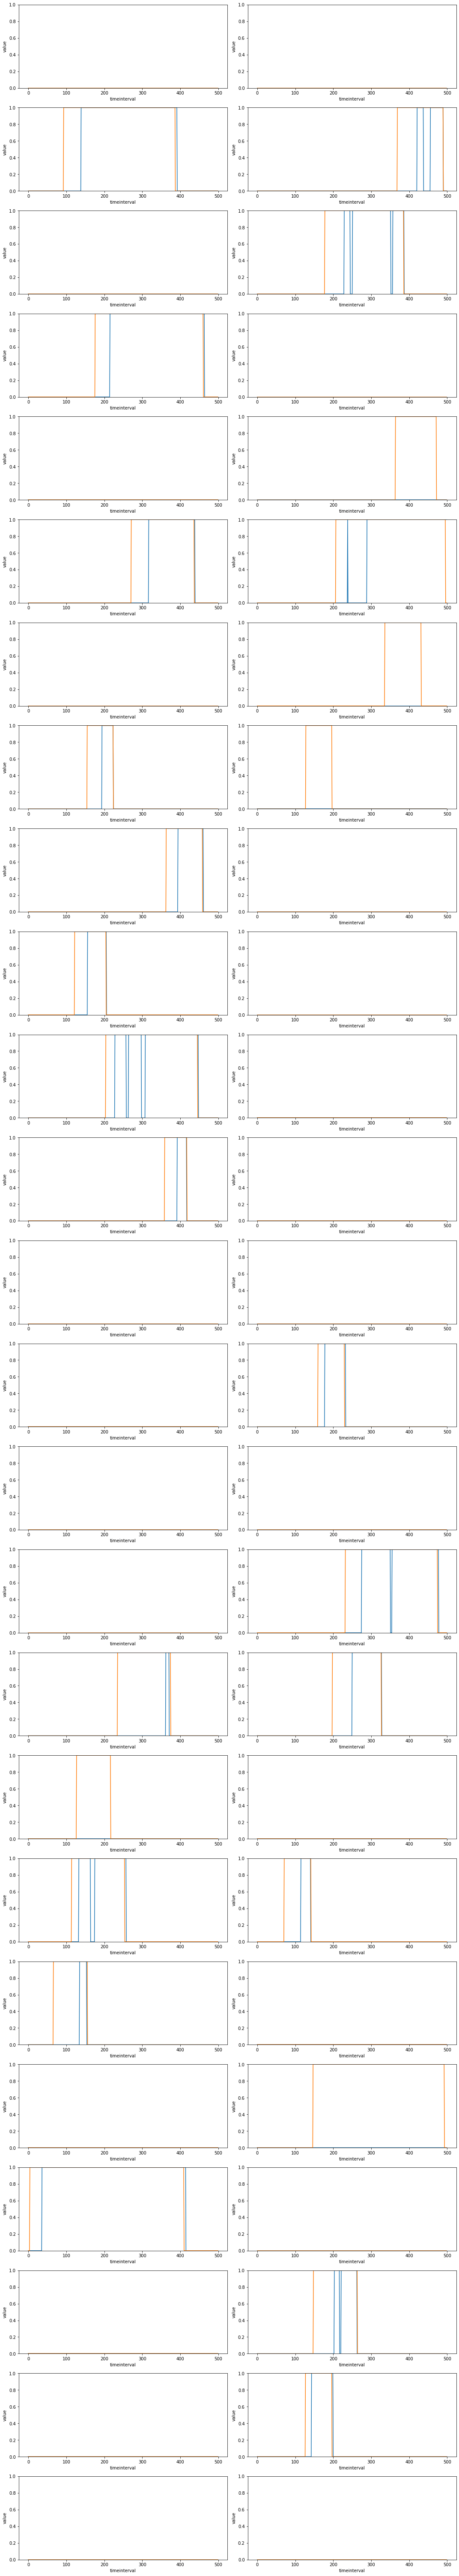

In [146]:
plt.figure(figsize=(15,100))
for index, sample in enumerate(Y_test[:50]):
    plt.subplot(30, 2, index+1)
    plt.ylim(0, 1)
    plt.plot(y_anomaly_prediction[index])
    plt.plot(y_anomaly_test[index])
    plt.xlabel('timeinterval')
    plt.ylabel('value')
    plt.tight_layout()

Имплементация результата будет производиться посредством кумулятивной оценки выхода нейронной сети 


In [347]:
# plt.figure(figsize=(30,15))
# plt.plot(Y_test[0])
# plt.plot(y_pred[0])
# plt.plot()
# plt.show()

In [15]:
model = Sequential()
input_layer = Input(shape=(500, 1))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
conv2 = Conv1D(filters=64,
               kernel_size=4,
               strides=1,
               activation='relu', 
               padding='same')(conv1)
flatten_conv = TimeDistributed(Flatten())(conv2)
output_layer = GRU(2, activation="softmax", return_sequences=True)(flatten_conv)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss="binary_crossentropy", optimizer="Adam")



In [16]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
4419/4419 [==============================] - 24s 5ms/step - loss: 0.5082
Epoch 2/50
4419/4419 [==============================] - 25s 6ms/step - loss: 0.4620
Epoch 3/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4584
Epoch 4/50
4419/4419 [==============================] - 24s 5ms/step - loss: 0.4579
Epoch 5/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4584
Epoch 6/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4567
Epoch 7/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4570
Epoch 8/50
4419/4419 [==============================] - 24s 5ms/step - loss: 0.4554
Epoch 9/50
4419/4419 [==============================] - 24s 5ms/step - loss: 0.4547
Epoch 10/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4535
Epoch 11/50
4419/4419 [==============================] - 23s 5ms/step - loss: 0.4556
Epoch 12/50
4419/4419 [==============================] - 22s 5ms/step - lo

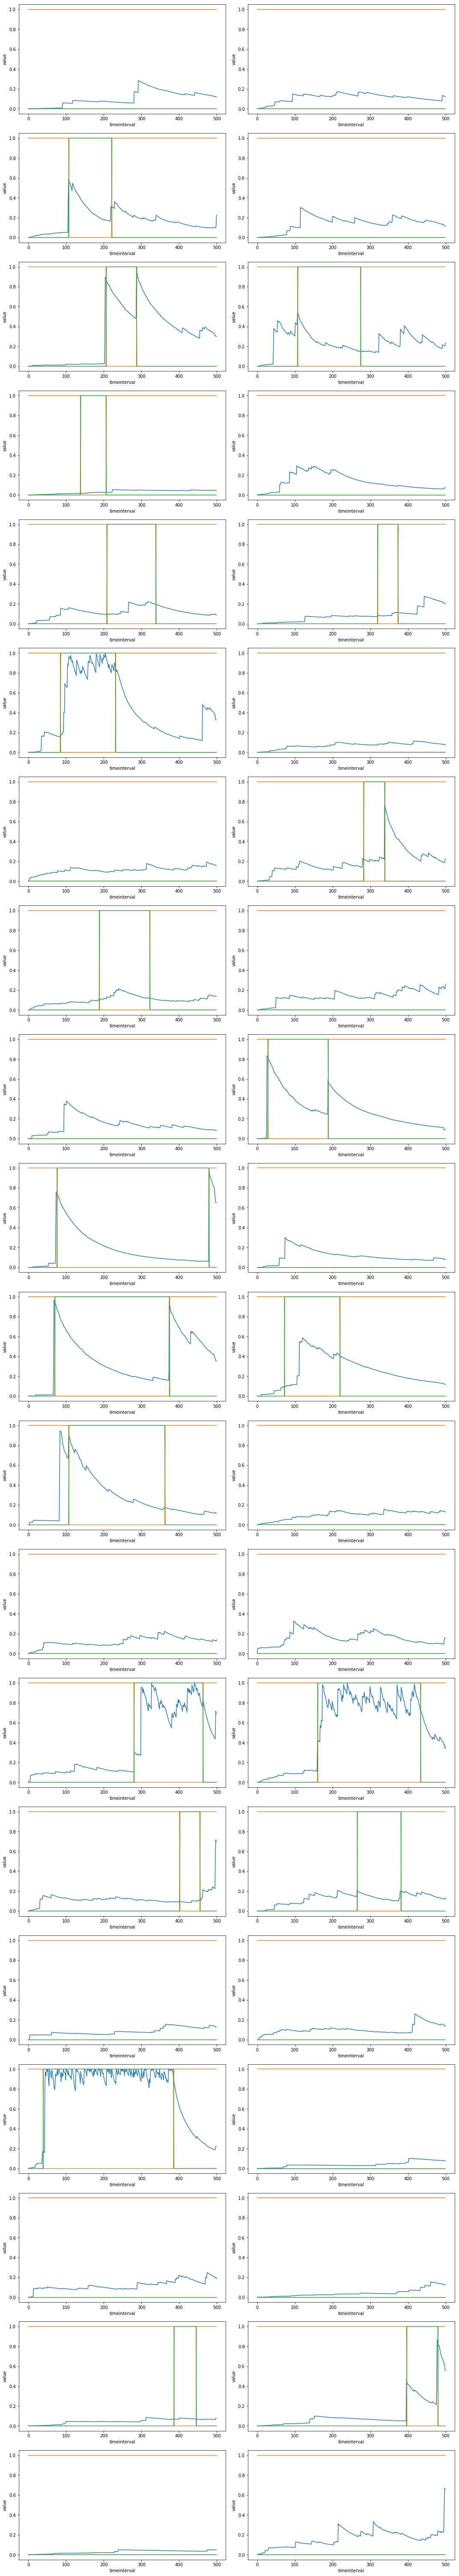

In [18]:
y_pred = model.predict(X_test)

plt.figure(figsize=(15,100))
for index, sample in enumerate(Y_test[:40]):
    plt.subplot(24, 2, index+1)
    plt.plot(y_pred[index][:,1])
    plt.plot(Y_test[index])
    plt.xlabel('timeinterval')
    plt.ylabel('value')
    plt.tight_layout()


# Conclusion

In [ ]:
kaspersky_set = pd.read_csv('datasets/attacks/attack_mode_0_type_21_id_246.csv', header=None)
for filename in os.listdir('datasets/attacks/')[1:]:
    data = pd.read_csv('datasets/attacks/' + filename, header=None)
    kaspersky_set = pd.concat([kaspersky_set,data])

In [33]:
kaspersky_set.to_csv('datasets/attacks/concate_attacks.csv')

False    552151
True      19557
Name: 55, dtype: int64

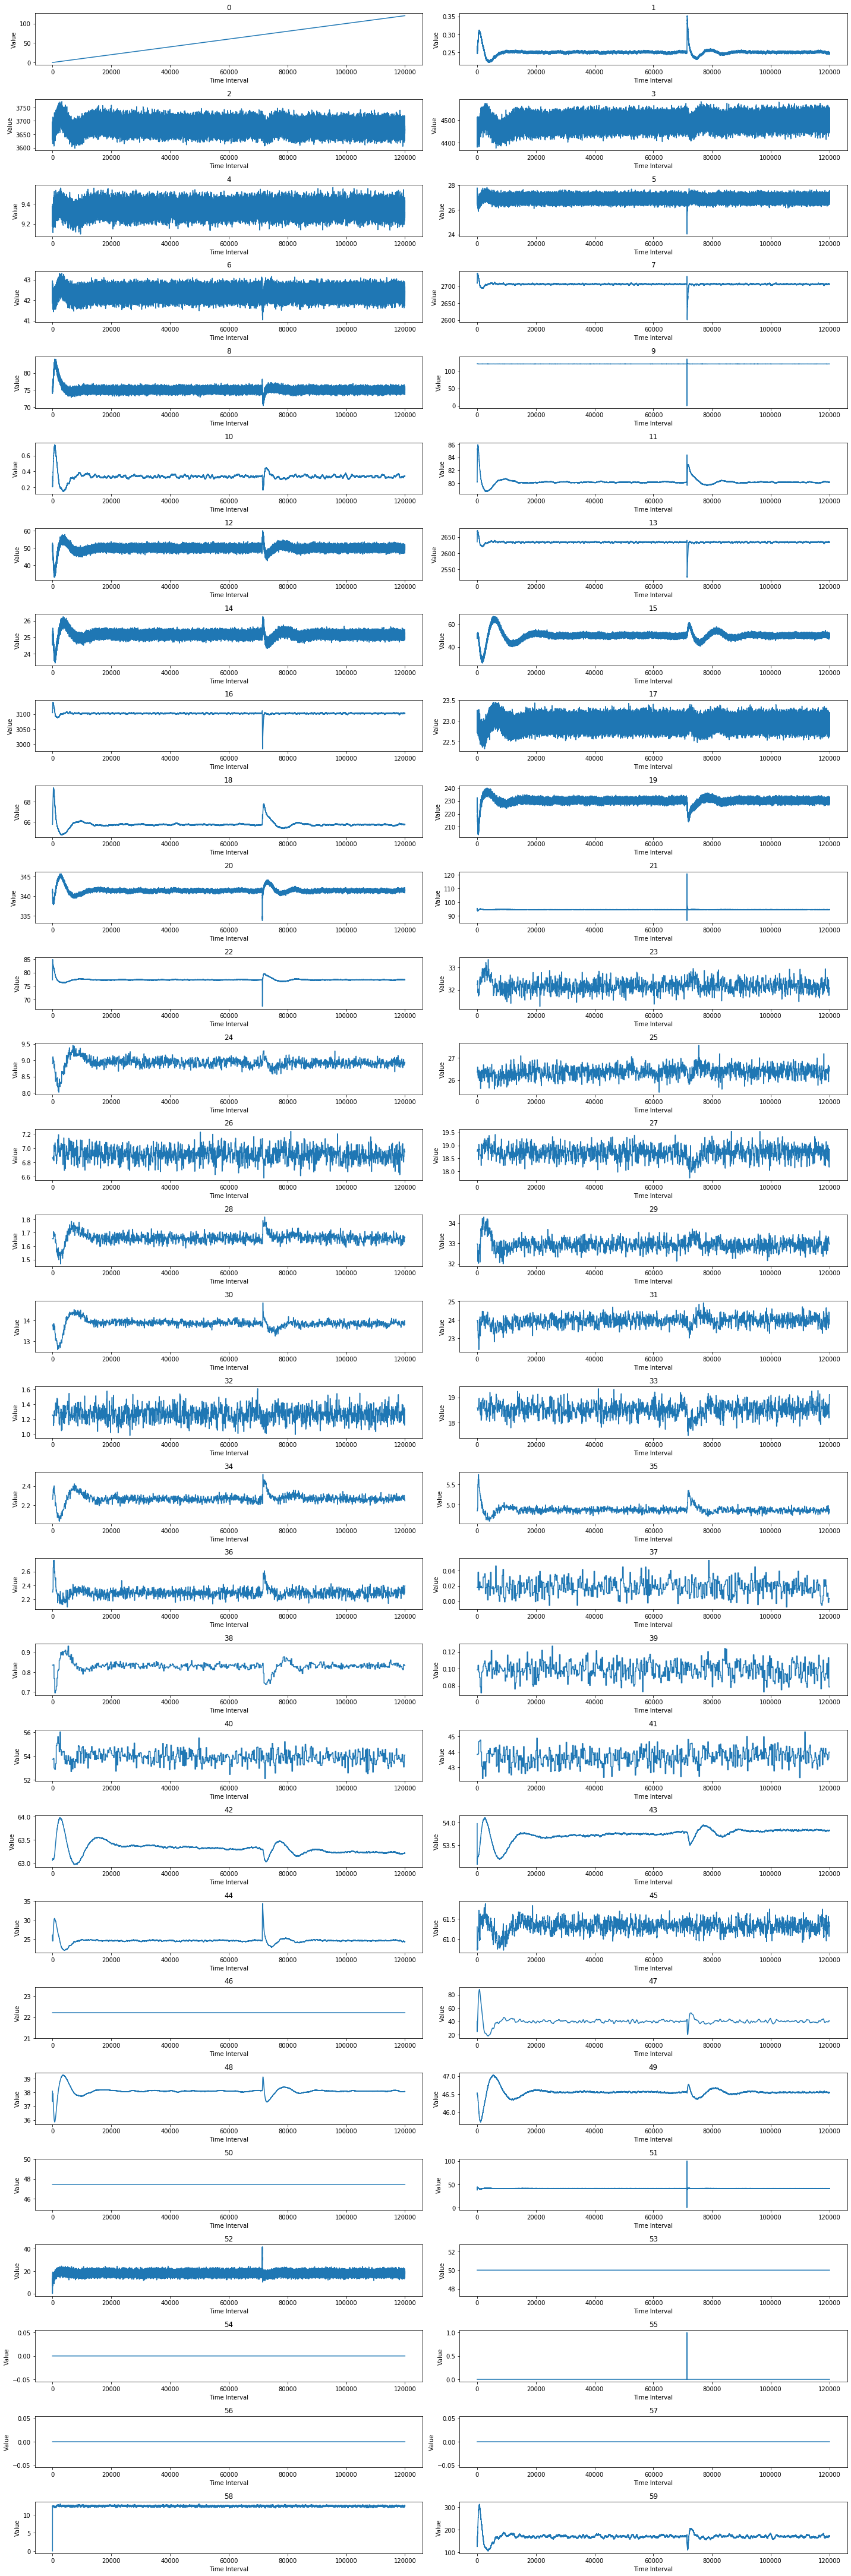

In [27]:
display_block_of_values(kaspersky_set,
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(50,2))

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))